CPSC 425 Assignment 1

Randy Li | 21133731

In [1]:
from PIL import Image as PILImage
import numpy as np 
import math
from scipy import signal
import cv2
from IPython.display import Image as IPImage
import time

In [2]:
def boxfilter(n):
    # Check if n is both positive and odd
    assert n > 0 and n % 2 != 0, "Invalid Dimension Value"
    return np.full((n,n), 1/(n*n))

In [3]:
boxfilter(3)

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]])

In [ ]:
boxfilter(4)

In [4]:
boxfilter(5)

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]])

In [5]:
def gauss1d(sigma):
    
    # Compute the length of array
    roundedUp = math.ceil(sigma * 6)
    len = roundedUp if roundedUp % 2 != 0 else roundedUp + 1

    # Generate a 0 centered array of specified length
    arr = np.arange(-1 * np.floor(len / 2), np.floor(len / 2) + 1)

    # Map the Gaussian function over the array
    filter = list(map(lambda x: np.exp(-x**2 / (2*sigma**2)), arr))

    # Normalization
    sum = np.sum(filter)
    result = filter / sum

    return result

In [6]:
gauss1d(0.3)

array([0.00383626, 0.99232748, 0.00383626])

In [7]:
gauss1d(0.5)

array([0.10650698, 0.78698604, 0.10650698])

In [8]:
gauss1d(1)

array([0.00443305, 0.05400558, 0.24203623, 0.39905028, 0.24203623,
       0.05400558, 0.00443305])

In [9]:
gauss1d(2)

array([0.0022182 , 0.00877313, 0.02702316, 0.06482519, 0.12110939,
       0.17621312, 0.19967563, 0.17621312, 0.12110939, 0.06482519,
       0.02702316, 0.00877313, 0.0022182 ])

In [10]:
def gauss2d(sigma):
    
    g1d = gauss1d(sigma)

    # Convolution of a 1D Gaussian filter and its transposition 
    g2d = signal.convolve2d(g1d[np.newaxis], g1d[np.newaxis].T)

    return g2d

In [ ]:
gauss2d(0.5)

In [ ]:
gauss2d(1)

In [11]:
def convolve2d_manual(array, filter):

    # Compute dimensions of both array and filter
    xArr, yArr = np.shape(array)
    xFil, yFil = np.shape(filter)
    
    # Compute padding dimensions
    xP = (xFil - 1) // 2
    yP = (yFil - 1) // 2

    # Apply padding to array
    array = np.pad(array, ((xP, xP), (yP, yP)), mode='constant', constant_values=0.0)

    # Convolution
    filter = np.rot90(filter, k=2)

    # Initiate output array
    output = np.zeros((xArr, yArr))

    for i in range(0, xArr):
        for j in range(0, yArr):
            paddedArr = array[i:(i+xFil), j:(j+yFil)]
            output[i,j] = np.sum(np.multiply(paddedArr, filter))                            
    
    return output


def gaussconvolve2d_manual(array, sigma):

    g2d = gauss2d(sigma)
    return convolve2d_manual(array, g2d)

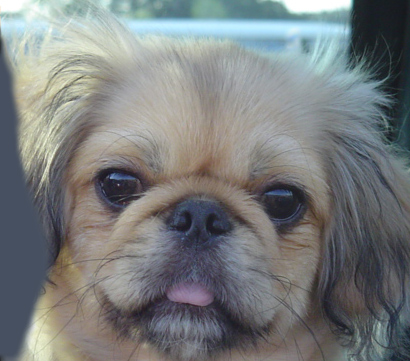

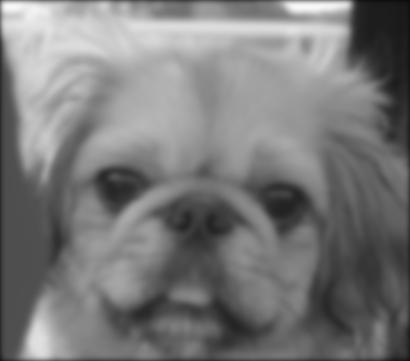

In [12]:
im = PILImage.open('dog.jpg')
display(IPImage(filename='dog.jpg'))

# Greyscale
imGS = im.convert('L')
imArr = np.asarray(imGS, dtype=np.float32)

# Apply filter
imFiltered = gaussconvolve2d_manual(imArr, 3)

# Save and display filtered image
imFiltered = PILImage.fromarray(imFiltered.astype('uint8'))
imFiltered.save('dog_Filtered.jpg', 'JPEG')
display(IPImage(filename='dog_Filtered.jpg'))

In [16]:
def gaussconvolve2d_scipy(array, sigma):
    
    filter = gauss2d(sigma)
    return signal.convolve2d(array, filter, 'same')

The reason why both ‘signal.convolve2d’ and ‘signal.correlate2d’ exist is because fundamentally they do different things. The former one flips the filter both horizontally and vertically before applying while the latter one doesn’t. 
The reason why the results are the same here is because the Gaussian filter is symmetric and the result is being computed with ‘same’ mode.

In [ ]:
imFiltered = gaussconvolve2d_scipy(imArr, 3)
imFiltered = PILImage.fromarray(imFiltered.astype('uint8'))
imFiltered.save('dog_Filtered2.jpg', 'JPEG')

display(IPImage(filename='dog.jpg'))
display(IPImage(filename='dog_Filtered2.jpg'))

In [ ]:
# Gaussian Filter (Manual)
t1 = time.time()
f1 = gaussconvolve2d_manual(imArr, 10)
duration1 = time.time() - t1
print("Gaussian Convolution (Manual) time is ", duration1)

# Gaussian Filter (Scipy)
t2 = time.time()
f2 = gaussconvolve2d_scipy(imArr, 10)
duration2 = time.time() - t2
print("Gaussian Convolution (Scipy) time is ", duration2)

Based on this we can see that the manual is roughly 2 times slower than the scipy one. Both used the gauss2d() function so it seems that signal.convolve2d() is just faster than my personal implementation. This could be due to various reasons, such as poor optimization on my part, or signal having a better algorithm, etc.

We can take advantage of the separability of 2D Gaussian filter because it can be expressed as two 1D Gaussian filters applied horizontally and vertically. So instead of applying 2D convolution directly, which results in O(m^2 * n^2) complexity (m is filter size), do each separately so it's O(2m * n^2) complexity, significantly improving its efficiency.

In [19]:
def blurredLP(img, sigma):

    # Convert image to array
    imArr = np.asarray(img, dtype=np.float32)
    imFilteredLP = np.zeros_like(imArr)

    # Apply convolution to each channel separately
    for i in range(3):
        imFilteredLP[:,:,i] = gaussconvolve2d_scipy(imArr[:,:,i], sigma)
    
    # Convert to type int8
    imFiltered = PILImage.fromarray(imFilteredLP.astype('uint8'))
    return imFiltered

In [ ]:
# Low-Pass Blur (Sigma = 10)
im = PILImage.open('0b_dog.bmp')
im.save('0b_dog.jpg', 'JPEG')
display(IPImage(filename='0b_dog.jpg'))
blurredLP(im, 10).save('0b_dog_LP.jpg', 'JPEG')
display(IPImage(filename='0b_dog_LP.jpg'))

In [21]:
def blurredHP(img, sigma):
    
    # Convert image to array
    imArr = np.asarray(img, dtype=np.float32)
    imArrLP = np.asarray(blurredLP(img, sigma), dtype=np.float32)

    # Original array - Low-Pass array
    imArrHP = imArr - imArrLP

    # Clipping image range and adding 128 for visualization
    imArrHP = np.clip(imArrHP+128, 0, 255)

    imFiltered = PILImage.fromarray(imArrHP.astype('uint8'))
    return imFiltered

In [ ]:
# High-Pass Blur (Sigma = 10)
im = PILImage.open('0a_cat.bmp')
im.save('0a_cat.jpg', 'JPEG')
display(IPImage(filename='0a_cat.jpg'))
blurredHP(im, 10).save('0a_cat_HP.jpg', 'JPEG')
display(IPImage(filename='0a_cat_HP.jpg'))

In [23]:
def hybridFil(img1, img2, sigma):
    
    # Convert images to arrays
    imArrLP1 = np.asarray(blurredLP(img1, sigma), dtype=np.float32)
    imArrLP2 = np.asarray(blurredLP(img2, sigma), dtype=np.float32)
    imArrOG2 = np.asarray(img2, dtype=np.float32)

    # High-Pass Blur
    imArrHP2 = imArrOG2 - imArrLP2

    # Adding Low-Pass and High-Pass together
    imArrHybrid = np.clip(imArrLP1 + imArrHP2, 0, 255)

    imFiltered = PILImage.fromarray(imArrHybrid.astype('uint8'))
    return imFiltered    

In [ ]:
# Hybrid (Sigma = 10)
im1 = PILImage.open('0a_cat.bmp')
im2 = PILImage.open('0b_dog.bmp')
hybridFil(im2, im1, 10).save('0a_0b_Hybrid10.jpg', 'JPEG')
display(IPImage(filename='0a_0b_Hybrid10.jpg'))

In [ ]:
# Hybrid (Sigma = 3)
im1 = PILImage.open('0a_cat.bmp')
im2 = PILImage.open('0b_dog.bmp')
hybridFil(im2, im1, 3).save('0a_0b_Hybrid3.jpg', 'JPEG')
display(IPImage(filename='0a_0b_Hybrid3.jpg'))

In [ ]:
# Hybrid (Sigma = 15)
im1 = PILImage.open('0a_cat.bmp')
im2 = PILImage.open('0b_dog.bmp')
hybridFil(im2, im1, 15).save('0a_0b_Hybrid15.jpg', 'JPEG')
display(IPImage(filename='0a_0b_Hybrid15.jpg'))

In [ ]:
# Hybrid (Sigma = 10)
im1 = PILImage.open('1a_bicycle.bmp')
im2 = PILImage.open('1b_motorcycle.bmp')
hybridFil(im2, im1, 10).save('1a_1b_Hybrid10.jpg', 'JPEG')
display(IPImage(filename='1a_1b_Hybrid10.jpg'))

In [ ]:
# Hybrid (Sigma = 3)
im1 = PILImage.open('1a_bicycle.bmp')
im2 = PILImage.open('1b_motorcycle.bmp')
hybridFil(im2, im1, 3).save('1a_1b_Hybrid3.jpg', 'JPEG')
display(IPImage(filename='1a_1b_Hybrid3.jpg'))

In [ ]:
# Hybrid (Sigma = 15)
im1 = PILImage.open('1a_bicycle.bmp')
im2 = PILImage.open('1b_motorcycle.bmp')
hybridFil(im2, im1, 15).save('1a_1b_Hybrid15.jpg', 'JPEG')
display(IPImage(filename='1a_1b_Hybrid15.jpg'))

In [ ]:
# Hybrid (Sigma = 10)
im1 = PILImage.open('2a_einstein.bmp')
im2 = PILImage.open('2b_marilyn.bmp')
hybridFil(im2, im1, 10).save('2a_2b_Hybrid10.jpg', 'JPEG')
display(IPImage(filename='2a_2b_Hybrid10.jpg'))

In [ ]:
# Hybrid (Sigma = 3)
im1 = PILImage.open('2a_einstein.bmp')
im2 = PILImage.open('2b_marilyn.bmp')
hybridFil(im2, im1, 3).save('2a_2b_Hybrid3.jpg', 'JPEG')
display(IPImage(filename='2a_2b_Hybrid3.jpg'))

In [ ]:
# Hybrid (Sigma = 15)
im1 = PILImage.open('2a_einstein.bmp')
im2 = PILImage.open('2b_marilyn.bmp')
hybridFil(im2, im1, 15).save('2a_2b_Hybrid15.jpg', 'JPEG')
display(IPImage(filename='2a_2b_Hybrid15.jpg'))

In [ ]:
bg = PILImage.open('box_gauss.png')
bs = PILImage.open('box_speckle.png')

imbg = np.asarray(bg).astype(np.uint8)
imbs = np.asarray(bs).astype(np.uint8)

# Gaussian Blur + Gaussian Noise
imbgarr = cv2.GaussianBlur(imbg, ksize=(0,0), sigmaX=3)
imbgfil = PILImage.fromarray(imbgarr.astype('uint8'))
imbgfil.save('box_gauss_gaussianblur.jpg', 'JPEG')
print("Gaussian Blur + Gaussian Noise:")
display(IPImage(filename='box_gauss_gaussianblur.jpg'))

# Gaussian Blur + Speckle Noise
imbsarr = cv2.GaussianBlur(imbs, ksize=(0,0), sigmaX=5)
imbsfil = PILImage.fromarray(imbsarr.astype('uint8'))
imbsfil.save('box_speckle_gaussianblur.jpg', 'JPEG')
print("Gaussian Blur + Speckle Noise:")
display(IPImage(filename='box_speckle_gaussianblur.jpg'))

# Bilateral Filter + Gaussian Noise
imbgarr = cv2.bilateralFilter(imbg, 5, sigmaColor=150, sigmaSpace=50)
imbgfil = PILImage.fromarray(imbgarr.astype('uint8'))
imbgfil.save('box_gauss_bilateralfilter.jpg', 'JPEG')
print("Bilateral Filter + Gaussian Noise:")
display(IPImage(filename='box_gauss_bilateralfilter.jpg'))

# Bilateral Filter + Speckle Noise
imbsarr = cv2.bilateralFilter(imbs, 6, sigmaColor=200, sigmaSpace=100)
imbsfil = PILImage.fromarray(imbsarr.astype('uint8'))
imbsfil.save('box_speckle_bilateralfilter.jpg', 'JPEG')
print("Bilateral Filter + Speckle Noise:")
display(IPImage(filename='box_speckle_bilateralfilter.jpg'))

# Median Blur + Gaussian Noise
imbgarr = cv2.medianBlur(imbg, 5)
imbgfil = PILImage.fromarray(imbgarr.astype('uint8'))
imbgfil.save('box_gauss_medianblur.jpg', 'JPEG')
print("Median Blur + Gaussian Noise:")
display(IPImage(filename='box_gauss_medianblur.jpg'))

# Median Blur + Speckle Noise
imbsarr = cv2.medianBlur(imbs, 7)
imbsfil = PILImage.fromarray(imbsarr.astype('uint8'))
imbsfil.save('box_speckle_medianblur.jpg', 'JPEG')
print("Median Blur + Speckle Noise:")
display(IPImage(filename='box_speckle_medianblur.jpg'))

In [34]:
def denoiseFilter(type):
    
    # Choosing type of noise
    if type == 'gauss':
        bg = PILImage.open('box_gauss.png')
        img = np.asarray(bg).astype(np.uint8)
        name = "Gaussian Noise"
        saveFile = "box_gauss.jpg"
    elif type == 'speckle':
        bs = PILImage.open('box_speckle.png')
        img = np.asarray(bs).astype(np.uint8)
        name = "Speckle Noise"
        saveFile = "box_speckle.jpg"

    # Application of filters
    gbarr = cv2.GaussianBlur(img, ksize=(7, 7), sigmaX=50)
    PILImage.fromarray(gbarr.astype('uint8')).save(f'gblur_{saveFile}', 'JPEG')
    print(f'Gaussian Blur + {name}')
    display(IPImage(filename=f'gblur_{saveFile}'))

    bfarr = cv2.bilateralFilter(img, 7, sigmaColor=150, sigmaSpace=150)
    PILImage.fromarray(bfarr.astype('uint8')).save(f'bfilter_{saveFile}', 'JPEG')
    print(f'Bilateral Filter + {name}')
    display(IPImage(filename=f'bfilter_{saveFile}'))

    mbarr = cv2.medianBlur(img,7)
    PILImage.fromarray(mbarr.astype('uint8')).save(f'mblur_{saveFile}', 'JPEG')
    print(f'Median Blur + {name}')
    display(IPImage(filename=f'mblur_{saveFile}'))

In [ ]:
denoiseFilter('gauss')

In [ ]:
denoiseFilter('speckle')

Gaussian Blur:
- Pros:
    -  Very time-efficient
- Cons:
    -  Not as good as BiFil and MediBlur at preserving edge sharpness

Bilateral Filter:
- Pros:
    -  Good at preserving edge sharpness
    -  Good at preserving texture 
- Cons:
    -  Not as time-efficient as Gaussian Blur
    -  Can fail to denoise in highly noisy regions

Median Blur:
- Pros:
    -  Good at denoising
    -  Good at preserving edge sharpness
- Cons:
    -  Can be computationally expensive, most expensive out of the three
    -  May lead to loss of fine details